Weekly class distribution:
class_week
2    0.417832
1    0.294580
0    0.287587
Name: proportion, dtype: float64


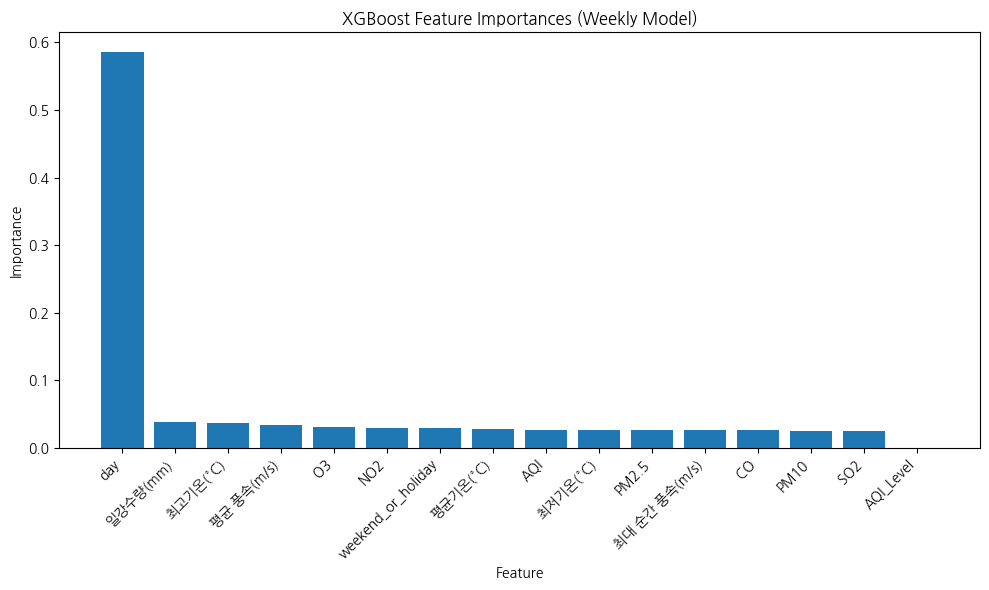


Test Accuracy: 0.8166

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        73
           1       0.82      0.82      0.82        68
           2       0.76      0.80      0.78        88

    accuracy                           0.82       229
   macro avg       0.82      0.82      0.82       229
weighted avg       0.82      0.82      0.82       229



In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib

warnings.filterwarnings('ignore')

# ───────────────────────────────────────────────────
# 1) 데이터 로드 및 정렬
# ───────────────────────────────────────────────────
df = pd.read_csv('Data/딥러닝 프로젝트/상관 체크용.csv', parse_dates=['ta_ymd'])
df.sort_values('ta_ymd', inplace=True)
df.set_index('ta_ymd', inplace=True)

# ───────────────────────────────────────────────────
# 2) 지난 1주일치 및 미래 1주일치 소비건수 합 계산
# ───────────────────────────────────────────────────
df['past_week_sum']   = df['cnt'].rolling(window=10, min_periods=10).sum().shift(1)
df['future_week_sum'] = df['cnt'].shift(-1).rolling(window=10, min_periods=10).sum()

# 마지막과 처음 주간이 완성되지 않는 행 제거
df = df.dropna(subset=['past_week_sum', 'future_week_sum'])

# ───────────────────────────────────────────────────
# 3) 주간 대비 증감율 계산
# ───────────────────────────────────────────────────
df['weekly_pct_change'] = (df['future_week_sum'] - df['past_week_sum']) / df['past_week_sum']

# ───────────────────────────────────────────────────
# 4) 클래스 라벨링 (상승↑ 1, 감소↓ 0, 중간 2)
# ───────────────────────────────────────────────────
# 예시: +10% 이상 상승→1, –10% 이하 감소→0, 그 외→2
pct_thr = 0.02
df['class_week'] = df['weekly_pct_change'].apply(
    lambda p: 1 if p >= pct_thr else (0 if p <= -pct_thr else 2)
)

# 클래스 분포 확인
print("Weekly class distribution:")
print(df['class_week'].value_counts(normalize=True))

# ───────────────────────────────────────────────────
# 5) 특성 선택 및 전처리
#    - 제외: 원본 cnt 및 주간 관련 지표, 타깃
#    - 범주형: AQI_Level, day, weekend_or_holiday (라벨 인코딩)
#    - 나머지 연속형: MinMax 스케일링
# ───────────────────────────────────────────────────
exclude = ['cnt', 'past_week_sum', 'future_week_sum', 'weekly_pct_change', 'class_week','평균구매단가','amt']
categorical_cols = ['AQI_Level', 'day', 'weekend_or_holiday']

# 라벨 인코딩
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 연속형 특성 추출
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c not in exclude + categorical_cols]

# 스케일링
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 최종 독립변수 리스트
features = features + categorical_cols

# ───────────────────────────────────────────────────
# 6) 학습/검증 데이터 준비
# ───────────────────────────────────────────────────
X = df[features].values
y = df['class_week'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ───────────────────────────────────────────────────
# 7) XGBoost 모델 학습
# ───────────────────────────────────────────────────
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# ───────────────────────────────────────────────────
# 8) 피처 중요도 시각화
# ───────────────────────────────────────────────────
importances = model.feature_importances_
fi_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fi_df['feature'], fi_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('XGBoost Feature Importances (Weekly Model)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────
# 9) 예측 및 평가
# ───────────────────────────────────────────────────
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Weekly class distribution:
class_week
2    0.417832
1    0.294580
0    0.287587
Name: proportion, dtype: float64


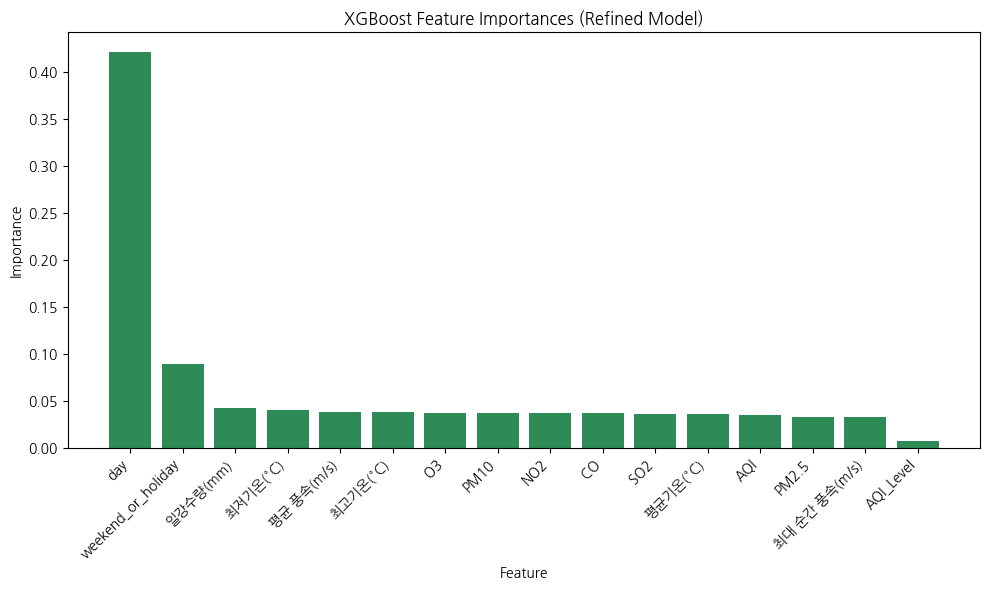


✅ Test Accuracy: 0.8384

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        73
           1       0.91      0.85      0.88        68
           2       0.76      0.89      0.82        88

    accuracy                           0.84       229
   macro avg       0.86      0.84      0.84       229
weighted avg       0.85      0.84      0.84       229



In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings
warnings.filterwarnings("ignore")

# ───────────────────────────────────────────────
# 1. 데이터 로딩 및 정렬
# ───────────────────────────────────────────────
df = pd.read_csv("Data/딥러닝 프로젝트/상관 체크용.csv", parse_dates=['ta_ymd'])
df.sort_values('ta_ymd', inplace=True)
df.set_index('ta_ymd', inplace=True)

# ───────────────────────────────────────────────
# 2. 과거/미래 1주일 합산 → 변화율 → 클래스 부여
# ───────────────────────────────────────────────
df['past_week_sum'] = df['cnt'].rolling(window=10, min_periods=10).sum().shift(1)
df['future_week_sum'] = df['cnt'].shift(-1).rolling(window=10, min_periods=10).sum()
df.dropna(subset=['past_week_sum', 'future_week_sum'], inplace=True)

df['weekly_pct_change'] = (df['future_week_sum'] - df['past_week_sum']) / df['past_week_sum']
pct_thr = 0.02
df['class_week'] = df['weekly_pct_change'].apply(
    lambda p: 1 if p >= pct_thr else (0 if p <= -pct_thr else 2)
)

# 클래스 분포 확인
print("Weekly class distribution:")
print(df['class_week'].value_counts(normalize=True))


# ───────────────────────────────────────────────
# 3. 특성 전처리
# ───────────────────────────────────────────────
exclude = ['cnt', 'past_week_sum', 'future_week_sum', 'weekly_pct_change', 'class_week', '평균구매단가', 'amt']
categorical_cols = ['AQI_Level', 'day', 'weekend_or_holiday']

# 라벨 인코딩
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 연속형 변수 스케일링
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c not in exclude + categorical_cols]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

features_refined = features + categorical_cols

# ───────────────────────────────────────────────
# 4. 입력 및 타겟 정의
# ───────────────────────────────────────────────
X = df[features_refined].values
y = df['class_week'].values

# 클래스 불균형 가중치 계산
weights = class_weight.compute_sample_weight('balanced', y)

# ───────────────────────────────────────────────
# 5. 학습/테스트 분리
# ───────────────────────────────────────────────
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, shuffle=False
)

# ───────────────────────────────────────────────
# 6. 모델 학습 (XGBoost)
# ───────────────────────────────────────────────
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)

# ───────────────────────────────────────────────
# 7. 피처 중요도 시각화
# ───────────────────────────────────────────────
importances = model.feature_importances_
fi_df = pd.DataFrame({
    'feature': features_refined,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fi_df['feature'], fi_df['importance'], color='seagreen')
plt.xticks(rotation=45, ha='right')
plt.title('XGBoost Feature Importances (Refined Model)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# 8. 예측 및 성능 평가
# ───────────────────────────────────────────────
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 불균형 방지하고자 샘플별로 가중치 주고,  트리 깊이 제한

Weekly class distribution:
class_week
2    0.417832
1    0.294580
0    0.287587
Name: proportion, dtype: float64


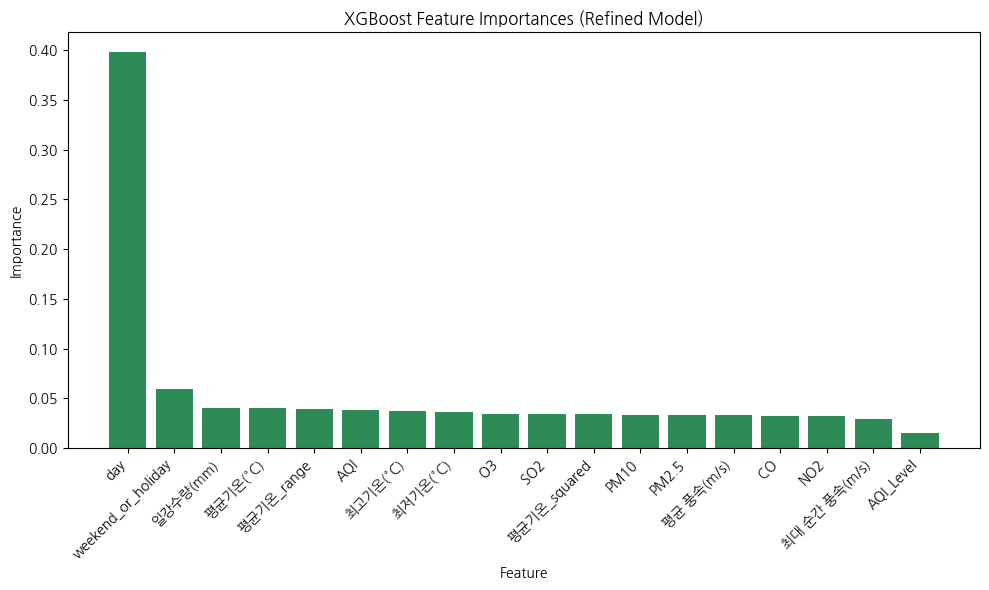


✅ Test Accuracy: 0.8428

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        73
           1       0.91      0.87      0.89        68
           2       0.76      0.88      0.81        88

    accuracy                           0.84       229
   macro avg       0.86      0.84      0.85       229
weighted avg       0.85      0.84      0.84       229



In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings
warnings.filterwarnings("ignore")

# ───────────────────────────────────────────────
# 1. 데이터 로딩 및 정렬
# ───────────────────────────────────────────────
df = pd.read_csv("Data/딥러닝 프로젝트/상관 체크용.csv", parse_dates=['ta_ymd'])
df.sort_values('ta_ymd', inplace=True)
df.set_index('ta_ymd', inplace=True)

# ───────────────────────────────────────────────
# 2. 과거/미래 1주일 합산 → 변화율 → 클래스 부여
# ───────────────────────────────────────────────
df['past_week_sum'] = df['cnt'].rolling(window=10, min_periods=10).sum().shift(1)
df['future_week_sum'] = df['cnt'].shift(-1).rolling(window=10, min_periods=10).sum()
df.dropna(subset=['past_week_sum', 'future_week_sum'], inplace=True)

df['weekly_pct_change'] = (df['future_week_sum'] - df['past_week_sum']) / df['past_week_sum']
pct_thr = 0.02
df['class_week'] = df['weekly_pct_change'].apply(
    lambda p: 1 if p >= pct_thr else (0 if p <= -pct_thr else 2)
)

# 클래스 분포 확인
print("Weekly class distribution:")
print(df['class_week'].value_counts(normalize=True))


# ───────────────────────────────────────────────
# 3. 특성 전처리
# ───────────────────────────────────────────────
exclude = ['cnt', 'past_week_sum', 'future_week_sum', 'weekly_pct_change', 'class_week', '평균구매단가', 'amt']
categorical_cols = ['AQI_Level', 'day', 'weekend_or_holiday']

# 라벨 인코딩
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 연속형 변수 스케일링
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c not in exclude + categorical_cols]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

features_refined = features + categorical_cols


# 추가 파생 피처: 평균기온 강조용
df['평균기온_squared'] = df['평균기온(°C)'] ** 2
df['평균기온_range'] = df['최고기온(°C)'] - df['최저기온(°C)']
np.random.seed(42)
df['평균기온(°C)'] += np.random.normal(0, 0.1, size=len(df))  # 약간의 노이즈로 split 유도

# features 목록에 반영
features_refined += ['평균기온_squared', '평균기온_range']

# ───────────────────────────────────────────────
# 4. 입력 및 타겟 정의
# ───────────────────────────────────────────────
X = df[features_refined].values
y = df['class_week'].values

# 클래스 불균형 가중치 계산
weights = class_weight.compute_sample_weight('balanced', y)

# ───────────────────────────────────────────────
# 5. 학습/테스트 분리
# ───────────────────────────────────────────────
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, shuffle=False
)

# ───────────────────────────────────────────────
# 6. 모델 학습 (XGBoost)
# ───────────────────────────────────────────────
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)

# ───────────────────────────────────────────────
# 7. 피처 중요도 시각화
# ───────────────────────────────────────────────
importances = model.feature_importances_
fi_df = pd.DataFrame({
    'feature': features_refined,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fi_df['feature'], fi_df['importance'], color='seagreen')
plt.xticks(rotation=45, ha='right')
plt.title('XGBoost Feature Importances (Refined Model)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# 8. 예측 및 성능 평가
# ───────────────────────────────────────────────
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 불균형 방지하고자 샘플별로 가중치 주고,  트리 깊이 제한
# 평균기온의 중요도를 더 높게 반영하도록 유도하고자  새로운 변수 추가하고 평균기온에 노이즈 추가

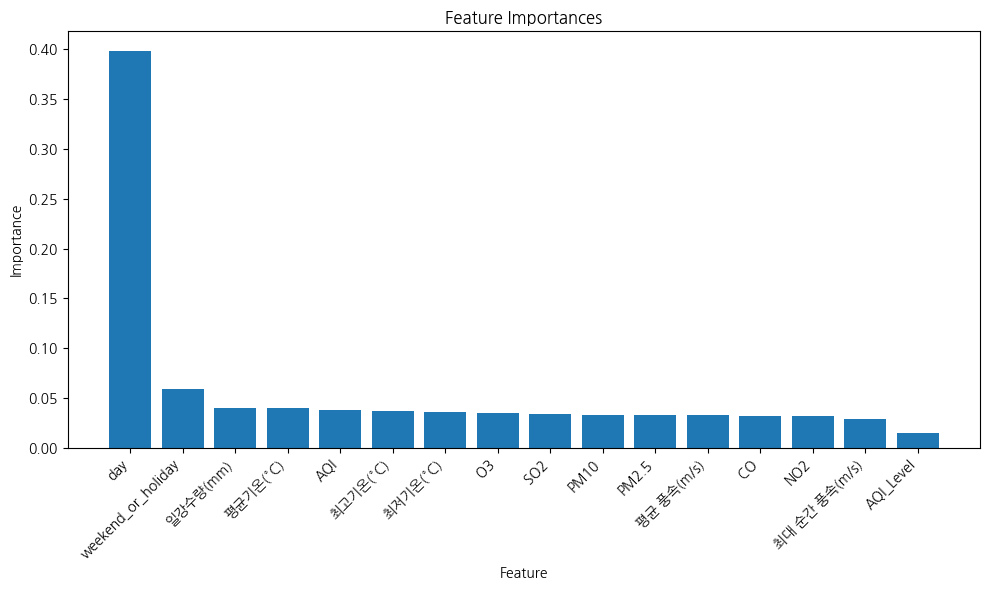

In [26]:
exclude_from_plot = ['평균기온_range', '평균기온_squared']
fi_df_filtered = fi_df[~fi_df['feature'].isin(exclude_from_plot)]

plt.figure(figsize=(10, 6))
plt.bar(fi_df_filtered['feature'], fi_df_filtered['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()